## Multilingual Language Classifier — End-to-End Notebook  

**This notebook demonstrates language classification tasks using the MASSIVE multilingual dataset.**
 
DATASET_LINK :  https://huggingface.co/datasets/qanastek/MASSIVE

```bash
00-Intro      │ project description, imports
01-Config     │ language list & helper dicts
02-DataLoad   │ MASSIVE download & split to train/val/test
03-EDA        │ bar plots of sentence length, class counts
04-TrainLang  │ TF-IDF + MultinomialNB  
05-TrainCont  │ TF-IDF + SVD + LDA & QDA 
06-SaveModels │ joblib.dump to artifacts/  (same paths as PredictPipeline)
07-Evaluate   │ confusion matrices & macro-accuracy on test split
08-QuickDemo  │ load pickles with your  PredictionPipeline()
```

In [2]:
# Core imports
import os,json,sys,warnings
import joblib,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from pathlib import Path
from typing import List, Tuple

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
                                          
warnings.filterwarnings("ignore")

In [3]:
# Setup directory and languages
massive_dataset = load_dataset("qanastek/MASSIVE", "en-US", split='test', trust_remote_code=True)
print(massive_dataset)
print(massive_dataset[0])

Dataset({
    features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
    num_rows: 2974
})
{'id': '0', 'locale': 'en-US', 'partition': 'test', 'scenario': 9, 'intent': 55, 'utt': 'wake me up at five am this week', 'annot_utt': 'wake me up at [time : five am] [date : this week]', 'tokens': ['wake', 'me', 'up', 'at', 'five', 'am', 'this', 'week'], 'ner_tags': [0, 0, 0, 0, 60, 16, 7, 37], 'worker_id': '1', 'slot_method': {'slot': [], 'method': []}, 'judgments': {'worker_id': [], 'intent_score': [], 'slots_score': [], 'grammar_score': [], 'spelling_score': [], 'language_identification': []}}


In [12]:
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

# Paths
# ARTIFACTS = "artifacts"
# os.makedirs(ARTIFACTS, exist_ok=True)

In [6]:
# 27 Roman-script locales
LANGS: List[str] = [
    'af-ZA','da-DK','de-DE','en-US','es-ES','fr-FR','fi-FI','hu-HU','is-IS','it-IT',
    'jv-ID','lv-LV','ms-MY','nb-NO','nl-NL','pl-PL','pt-PT','ro-RO','ru-RU','sl-SL',
    'sv-SE','sq-AL','sw-KE','tl-PH','tr-TR','vi-VN','cy-GB'
]

In [7]:
# locale → continent
continent_lookup = {
    'ZA':'Africa','KE':'Africa','AL':'Europe','GB':'Europe','DK':'Europe','DE':'Europe',
    'ES':'Europe','FR':'Europe','FI':'Europe','HU':'Europe','IS':'Europe','IT':'Europe',
    'ID':'Asia','LV':'Europe','MY':'Asia','NO':'Europe','NL':'Europe','PL':'Europe',
    'PT':'Europe','RO':'Europe','RU':'Europe','SL':'Europe','SE':'Europe','PH':'Asia',
    'TR':'Asia','VN':'Asia','US':'North America'
}

# continent_lookup = dict(
#     ZA="Africa", KE="Africa",
#     AL="Europe", GB="Europe", DK="Europe", DE="Europe", ES="Europe", FR="Europe",
#     FI="Europe", HU="Europe", IS="Europe", IT="Europe", LV="Europe", NO="Europe",
#     NL="Europe", PL="Europe", PT="Europe", RO="Europe", RU="Europe", SL="Europe",
#     SE="Europe",
#     ID="Asia", MY="Asia", PH="Asia", TR="Asia", VN="Asia",
#     US="North America",
# )

# def to_continent(locale): return CONTINENT.get(locale.split("-")[1], "Unknown")

In [8]:
def map_continent(locale:str)->str:
    return continent_lookup[locale.split('-')[1]]

In [ ]:
def load_massive_splits(locales:List[str])->Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    """Loads train/validation/test once per locale (cached)."""
    
    buckets = {"train":[], "validation":[], "test":[]}
    for loc in locales:
        ds = load_dataset("qanastek/MASSIVE", loc, trust_remote_code=True)
        for split in buckets:
            tmp = pd.DataFrame(ds[split])[["utt"]].copy()
            tmp["locale"] = loc
            buckets[split].append(tmp)
            
    dfs = {k: pd.concat(v, ignore_index=True) for k,v in buckets.items()}

    for df in dfs.values():
        df["continent"] = df["locale"].apply(map_continent)
    return dfs["train"], dfs["validation"], dfs["test"]

In [ ]:
# # Load Datasets

# def load_split(langs, split):
#     frames = []
#     for loc in langs:
#         ds = load_dataset("qanastek/MASSIVE", loc, split=split, trust_remote_code=True)
#         df = pd.DataFrame(ds)[["locale","utt"]]
#         df["split"] = split
#         frames.append(df)
#     return pd.concat(frames, ignore_index=True)

# train_df = load_split(LANGS,"train")
# val_df   = load_split(LANGS,"validation")
# test_df  = load_split(LANGS,"test")

# for df in (train_df,val_df,test_df):
#     df["continent"] = df["locale"].apply(to_continent)

# print(train_df.shape, val_df.shape, test_df.shape)


In [10]:
# Load Data
print("🗃  Loading MASSIVE splits ... (first run may take ~2-3 min)")
train_df, val_df, test_df = load_massive_splits(LANGS)
print("Shapes:", train_df.shape, val_df.shape, test_df.shape)

🗃  Loading MASSIVE splits ... (first run may take ~2-3 min)
Shapes: (310878, 3) (54891, 3) (80298, 3)


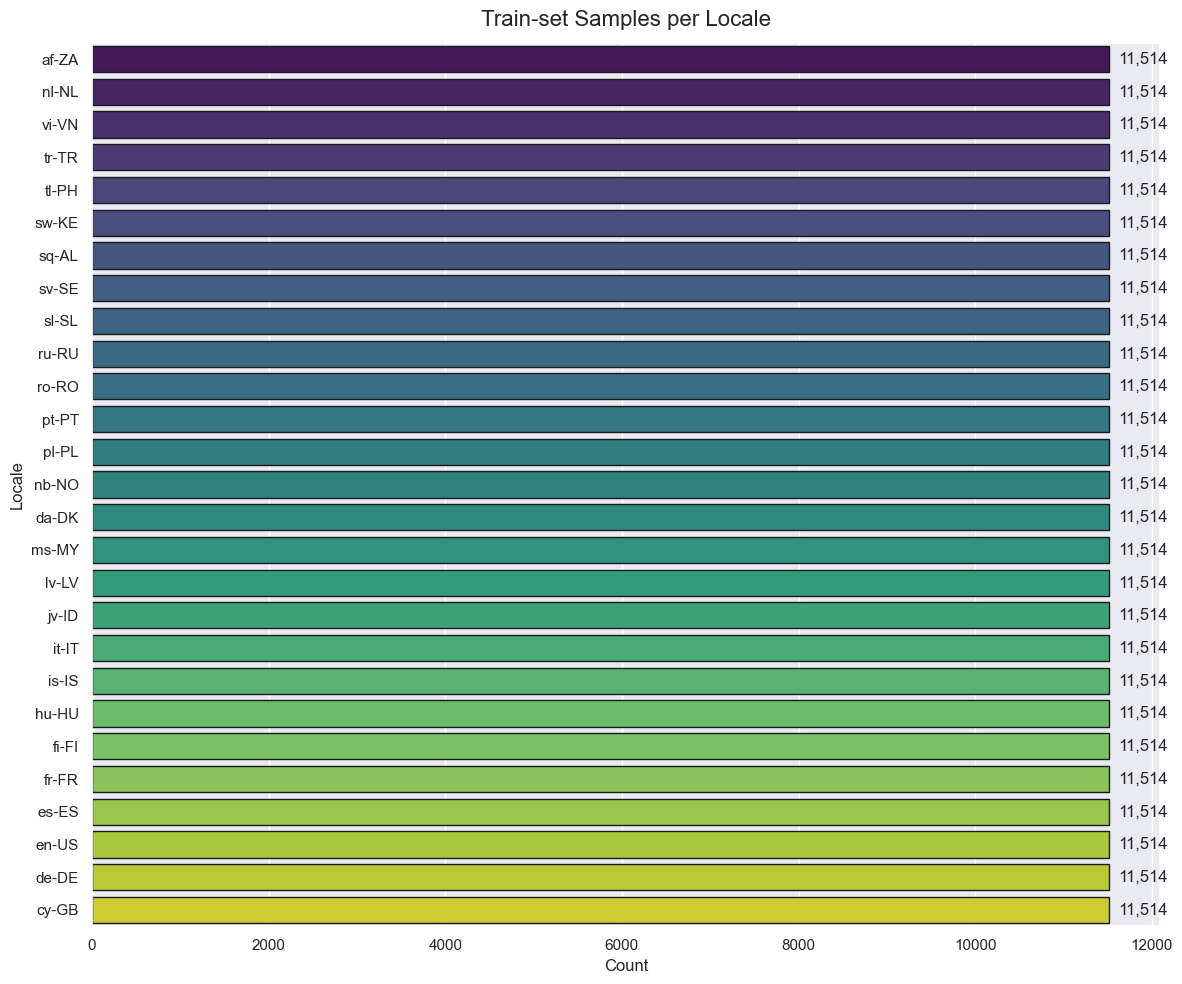

In [ ]:
# EDA Plots
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 10))

order = train_df["locale"].value_counts().index

sns.countplot(
    data=train_df,
    y="locale",
    order=order,
    ax=ax,
    palette="viridis",
    edgecolor="k"
)

ax.set_title("Train-set Samples per Locale", fontsize=16, pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Locale")

for p in ax.patches:
    w = p.get_width()
    ax.text(w + 100, p.get_y() + p.get_height()/2,
            f"{int(w):,}", va="center")

plt.tight_layout()
fig.savefig(ARTIFACTS / "samples_per_locale.png", dpi=300)
plt.show()


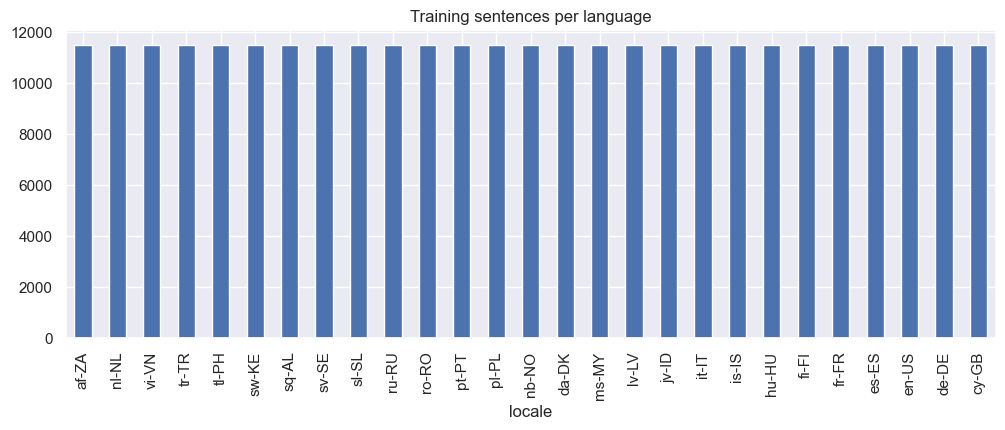

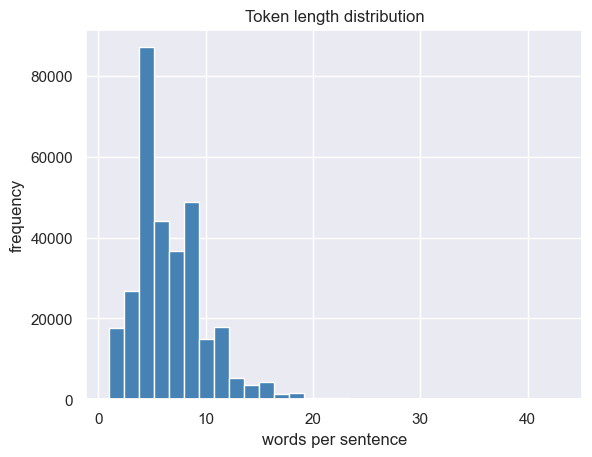

In [ ]:
# EDA Plots
# Just For Visualization
plt.figure(figsize=(12,4))
train_df['locale'].value_counts().plot(kind='bar')
plt.title("Training sentences per language")
plt.show()

# Sentence length histogram
lens = train_df['utt'].str.split().apply(len)
plt.hist(lens, bins=30, color='steelblue')
plt.title("Token length distribution")
plt.xlabel("words per sentence"); plt.ylabel("frequency")
plt.show()


In [ ]:
# LANGUAGE MODEL

print("\n🔠 Training language classifier ...")
lang_pipe = make_pipeline(
    TfidfVectorizer(analyzer="char_wb", ngram_range=(1,3), max_features=10000),
    MultinomialNB(alpha=0.1))
lang_pipe.fit(train_df.utt, train_df.locale)

val_pred = lang_pipe.predict(val_df.utt)
test_pred= lang_pipe.predict(test_df.utt)
print("Validation acc:", accuracy_score(val_df.locale,val_pred).round(4))
print("Test acc:", accuracy_score(test_df.locale,test_pred).round(4))
print(classification_report(val_df.locale,val_pred)[:700])

cm = confusion_matrix(val_df.locale, val_pred, labels=LANGS)
fig2 = plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="mako", cbar=False, xticklabels=False, yticklabels=False)
plt.title("Language confusion matrix (val)"); plt.tight_layout()
fig2.savefig(ARTIFACTS/"lang_confusion.png"); plt.close()


🔠 Training language classifier ...


In [ ]:
# CONTINENT MODEL 

print("\n🌍 Training continent classifier ...")
vec = TfidfVectorizer(max_features=15000)
X_train = vec.fit_transform(train_df.utt)
X_val   = vec.transform(val_df.utt)
X_test  = vec.transform(test_df.utt)

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_r = svd.fit_transform(X_train)
X_val_r   = svd.transform(X_val)
X_test_r  = svd.transform(X_test)

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train_r, train_df.continent)
qda.fit(X_train_r, train_df.continent)

print("LDA Validation acc:", accuracy_score(val_df.continent, lda.predict(X_val_r)).round(4))
print("LDA Test acc      :", accuracy_score(test_df.continent, lda.predict(X_test_r)).round(4))
print("\n",classification_report(val_df.continent, lda.predict(X_val_r)))

print("QDA Validation acc:", accuracy_score(val_df.continent, qda.predict(X_val_r)).round(4))
print("QDA Test acc      :", accuracy_score(test_df.continent, qda.predict(X_test_r)).round(4))

In [ ]:
# ROC curve for LDA (one-vs-rest)

from sklearn.preprocessing import label_binarize
classes = ["Africa","Asia","Europe","North America"]
y_val_bin = label_binarize(val_df.continent, classes)
y_score   = lda.predict_proba(X_val_r)
fig3 = plt.figure(figsize=(6,4))
for i,c in enumerate(classes):
    fpr,tpr,_ = roc_curve(y_val_bin[:,i], y_score[:,i])
    plt.plot(fpr,tpr,label=f"{c} AUC:{auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title("LDA ROC curves"); plt.tight_layout()
fig3.savefig(ARTIFACTS/"lda_roc.png"); plt.close()

In [ ]:
# SAVE ARTEFACTS 
print("\n💾 Saving artefacts to 'artifacts/' ...")
joblib.dump(lang_pipe,          ARTIFACTS/"language_pipeline.pkl")
joblib.dump(vec,                ARTIFACTS/"continent_vectorizer.pkl")
joblib.dump(svd,                ARTIFACTS/"continent_svd.pkl")
joblib.dump(lda,                ARTIFACTS/"continent_lda_model.pkl")
joblib.dump(qda,                ARTIFACTS/"continent_qda_model.pkl")

In [ ]:
# Label encoder for continents

import pickle, json
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(classes)
joblib.dump(le, ARTIFACTS/"continent_label_encoder.pkl")

perf = {
    "language_val_acc": float(accuracy_score(val_df.locale,val_pred)),
    "language_test_acc": float(accuracy_score(test_df.locale,test_pred)),
    "continent_val_acc": float(accuracy_score(val_df.continent, lda.predict(X_val_r))),
    "continent_test_acc": float(accuracy_score(test_df.continent, lda.predict(X_test_r)))
}
with open(ARTIFACTS/"model_performance.pkl","wb") as f: pickle.dump(perf,f)

In [ ]:
#  SMOKE TEST 
print("\n🚦 Reloading pickles for smoke-test ...")
lang_pipe2 = joblib.load(ARTIFACTS/"language_pipeline.pkl")
lda2       = joblib.load(ARTIFACTS/"continent_lda_model.pkl")
vec2       = joblib.load(ARTIFACTS/"continent_vectorizer.pkl")
svd2       = joblib.load(ARTIFACTS/"continent_svd.pkl")
le2        = joblib.load(ARTIFACTS/"continent_label_encoder.pkl")

print("Reloaded language test acc:",
      accuracy_score(test_df.locale, lang_pipe2.predict(test_df.utt)).round(4))
X_test_r2 = svd2.transform(vec2.transform(test_df.utt))
print("Reloaded LDA continent test acc:",
      accuracy_score(test_df.continent, lda2.predict(X_test_r2)).round(4))

samples = ["Hello how are you?",
           "Bonjour, comment ça va?",
           "Guten Tag, wie geht's?"]
print("\nSample predictions:")
for s in samples:
    lang = lang_pipe2.predict([s])[0]
    cont = le2.inverse_transform([lda2.predict(svd2.transform(vec2.transform([s])))])
    print(f"  '{s[:25]}...' ➜ {lang} / {cont}")

print("Done ✔")